# Task 1 - LULC tile location map

## General instructions

First, update the following cell to have a link to your Homework 4 GitHub repository

**UPDATE THIS LINK**  https://github.com/hazelvaq/eds220-hwk-4.git

Add comments for all your code and commit as needed. Err on the side of commenting and commiting too much for now.

## Overview
The goal of this task is to create a simple map showing the location of the LULC tile section we used in the previous discussion section relative to the state of California and Mount Whitney. 

## About the data

In this task you will use two datsets:

**First dataset**

A small section of the GAP/LANDFIRE National Terrestrial Ecosystems data for 2011, from the US Geological Survey (USGS). This is a raster file with a 30 m x 30 m pixel resolution. Each cell in the raster has a number representing the type of land cover.

The data was pre-processed in the Microsoft Planetary Computer to show a small region around Mount Whitney in California.

Further information about the dataset can be accessed via the the dataset’s Digital Object Identifier (DOI) link:

U.S. Geological Survey (USGS) Gap Analysis Project (GAP), 2016, GAP/LANDFIRE National Terrestrial Ecosystems 2011: U.S. Geological Survey data release, https://doi.org/10.5066/F7ZS2TM0.

**Second dataset**

A shapefile of CA Geographic Boundaries. 
This is a subset of the US Census Bureau's 2016 TIGER database, which only has the state boundary.
[https://data.ca.gov/dataset/ca-geographic-boundaries/resource/3db1e426-fb51-44f5-82d5-a54d7c6e188b](https://data.ca.gov/dataset/ca-geographic-boundaries/resource/3db1e426-fb51-44f5-82d5-a54d7c6e188b)

## File management
All your data files must be  inside a directory named 'data'  **in your gitignore**. 

## Data access
The .tif file (same as we used in discussion section) is in the Canvas-week7-homework zip file. The California shapefile will be directly accessed via its URL.

## FINAL CODE
You will use the next cell at the end of the task. Leave it blank for now.

In [ ]:
### ===== FINAL CODE =====

## Import libraries and functions

In [33]:
# import libraries and functions here
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches 

## for geospatial
import xarray as xr
import rioxarray as rioxr
import geopandas as gpd

from rasterio.features import rasterize 
from shapely.geometry import box


## Import data
Use the next two cells to:

1. Import the raster file and store it in a variable `lulc` and take a look at it.
2. Import the CA shapefile directly from the URL using `gpd.read_file()` and take a look at it. You can get it by right-clicking on the "Download" button. Store it as a variable named `ca`.

In [3]:
# 1 Import the raster file 
lulc = rioxr.open_rasterio(os.path.join(os.getcwd(),'data','land_cover.tif'))

lulc

<xarray.DataArray (band: 1, y: 3000, x: 3000)>
[9000000 values with dtype=uint16]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -2.031e+06 -2.031e+06 ... -1.941e+06 -1.941e+06
  * y            (y) float64 1.762e+06 1.762e+06 ... 1.672e+06 1.672e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  2 (pixels/inch)
    TIFFTAG_SOFTWARE:        ERDAS IMAGINE
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    scale_factor:            1.0
    add_offset:              0.0

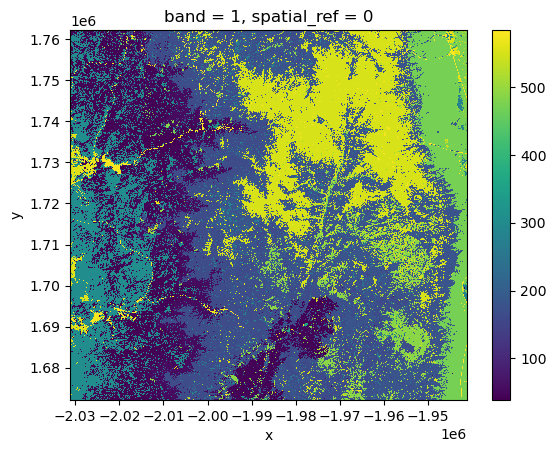

In [4]:
#Take a look at the raster
lulc.plot()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   REGION    1 non-null      object  
 1   DIVISION  1 non-null      object  
 2   STATEFP   1 non-null      object  
 3   STATENS   1 non-null      object  
 4   GEOID     1 non-null      object  
 5   STUSPS    1 non-null      object  
 6   NAME      1 non-null      object  
 7   LSAD      1 non-null      object  
 8   MTFCC     1 non-null      object  
 9   FUNCSTAT  1 non-null      object  
 10  ALAND     1 non-null      int64   
 11  AWATER    1 non-null      int64   
 12  INTPTLAT  1 non-null      object  
 13  INTPTLON  1 non-null      object  
 14  geometry  1 non-null      geometry
dtypes: geometry(1), int64(2), object(12)
memory usage: 248.0+ bytes


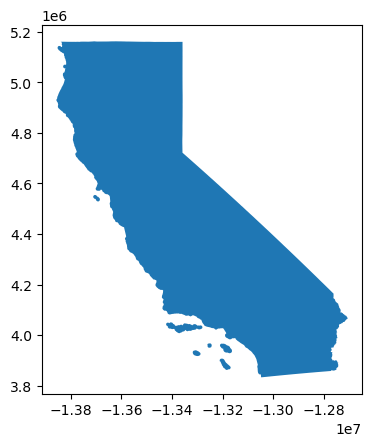

In [5]:
# 2 Import the CA shapefile 
ca = gpd.read_file('https://data.ca.gov/dataset/e212e397-1277-4df3-8c22-40721b095f33/resource/3db1e426-fb51-44f5-82d5-a54d7c6e188b/download/ca-state-boundary.zip')

# Take a look at the shapefile 
ca.plot()

ca.info()

## Bounding box
Create a `geopandas.GeoDataFrame` named `bbox` with the lulc bounding box. 

lulc crs: EPSG:3857
ca_crs: epsg:3857
lulc updated CRS: EPSG:3857


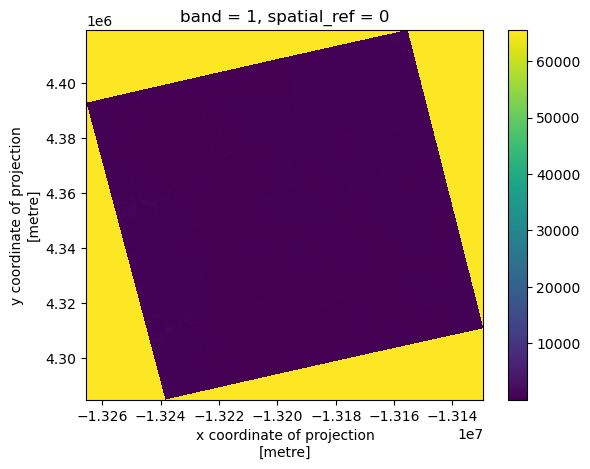

In [20]:
# Create a dataframe with the lulc bounding box

# Check CRS of lulc is the same as ca
print(f"lulc crs: {lulc.rio.crs}\nca_crs: {ca.crs}") # they are not equal

# reproject lulc to match ca CRS
lulc = lulc.rio.reproject(ca.crs)

#Check if CRS has been updates
print(f"lulc updated CRS: {lulc.rio.crs}")

# Print reprojected lulc map
lulc.plot()

It seems like there are no-data values in the reprojected `lulc` 

In [29]:
# check min and max 
print(f"min: {lulc.min().item():,}, max: {lulc.max().item():}")

# get no-data value
nodata = lulc.rio.nodata
print('no-data value', nodata)

# select pixels with data using where()
lulc = lulc.where(lulc != nodata)

min: 39, max: 65535
no-data value 65535


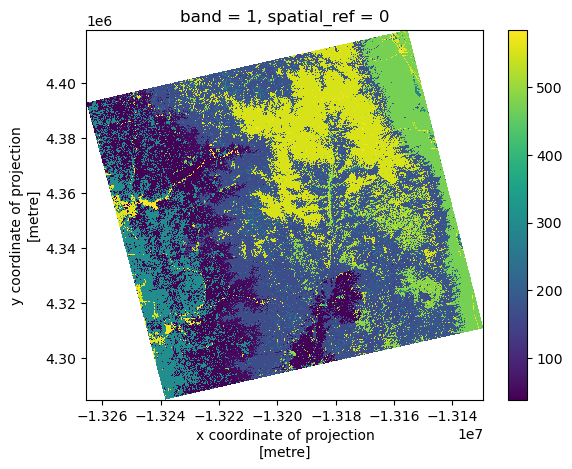

In [30]:
# check graph with nodata
lulc.plot()

In [35]:
box(*lulc.total_bounds)

AttributeError: 'DataArray' object has no attribute 'total_bounds'

## Mount Whitney point
Create a `geopands.GeoDataFrame` named `mt_whitney` having the coordinates of Mount Whitney as a single point. You will need to look up Mount Whitney's coordinates. HINT: [`shapely.Point()`](https://shapely.readthedocs.io/en/stable/reference/shapely.Point.html)

In [ ]:
# your code here

## Updates
If there are any updates needed to the data, perform them in the next cells (you may add as many as you need). 
At the top of each one, include a comment explaining what is happening in that cell's code.

In [ ]:
# your code here

## Map

Create a map showing `bbox`, `ca` and `mt_whitney` similar to the one in the overview section. 
It must have at least the customizations shown in the sample map. 

HINTS:
1. to change the `marker_style`: https://matplotlib.org/stable/gallery/lines_bars_and_markers/marker_reference.html
2. to add the marker to the legend: https://matplotlib.org/stable/users/explain/axes/legend_guide.html and update parameter `linestyle='None'` in `mlines.Line2D`

In [ ]:
# your code here

## Final code
Collect all the relevant code into the first blank cell of the notebook titled "FINAL CODE". This single cell will have the end-to-end workflow: from importing libraries and loading the data, to producing the graph. The only ouput of this cell should be the graph you produced in the previous exercise. 

Add divisions for relevant sections and comment appropriately.
